## Tarea de visión por computadora y métricas de evaluación

La tarea a resolver es un problema de **clasificación multiclase** de imágenes con una sola etiqueta por muestra.  
Cada imagen del dataset TrashNet

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

import shutil
import os

# Ensure only the 'dataset-resized' folder is placed in the project root
root_dir = os.getcwd()
src_dataset_dir = os.path.join(path, "dataset-resized")
alt_src_dataset_dir = os.path.join(root_dir, "1", "dataset-resized")
dest_dataset_dir = os.path.join(root_dir, "dataset-resized")

# Prefer moving from an existing '1/dataset-resized' if present to avoid duplicates
if os.path.exists(alt_src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    shutil.move(alt_src_dataset_dir, dest_dataset_dir)
    # Remove empty '1' dir if it's now empty
    try:
        os.rmdir(os.path.join(root_dir, "1"))
    except OSError:
        pass
    print("Dataset moved from '1' to:", dest_dataset_dir)
elif os.path.exists(src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    # Copy the dataset instead of moving it due to read-only filesystem
    shutil.copytree(src_dataset_dir, dest_dataset_dir)
    print("Dataset copied to:", dest_dataset_dir)
else:
    raise FileNotFoundError("No 'dataset-resized' folder found in download path.")

Using Colab cache for faster access to the 'trashnet' dataset.
Path to dataset files: /kaggle/input/trashnet
Dataset copied to: /content/dataset-resized


## Análisis Exploratorio de Datos
  1) Análisis de distribución de colores
  2) Análisis de bounding boxes
  3) Analisis de distribución de etiquetas
  4) Dimensión de imagenes y relación de aspectos
  5) Calidad de imágenes

### Visializacion del Dataset

Clases encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


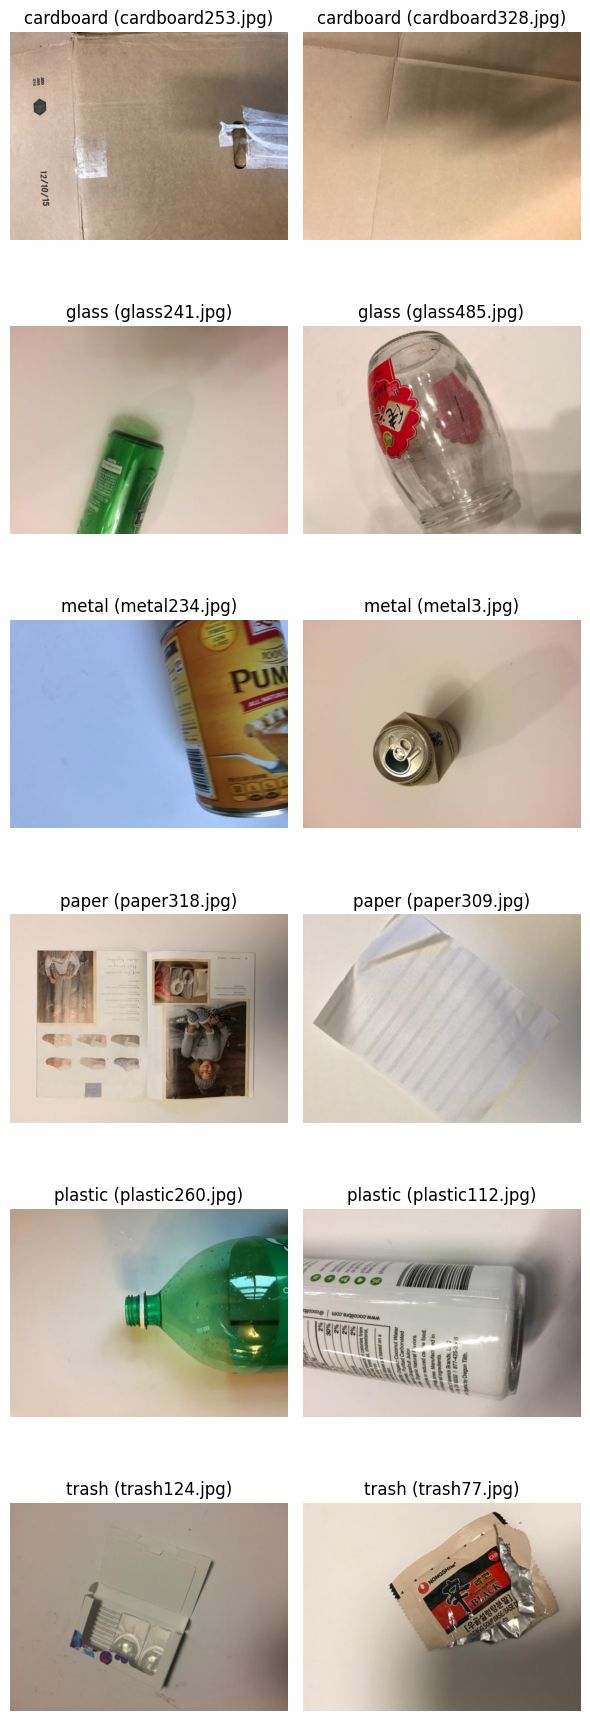

In [26]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Ruta del dataset
dataset_dir = "dataset-resized"

# Obtener las clases (subcarpetas)
classes = sorted(os.listdir(dataset_dir))
print("Clases encontradas:", classes)

# Crear una figura
fig, axes = plt.subplots(len(classes), 2, figsize=(6, 3 * len(classes)))

for i, cls in enumerate(classes):
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)

    # Seleccionar 2 imágenes al azar
    sample_images = random.sample(images, 2)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{cls} ({img_name})")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


### Análisis visual por clase

Se revisaron ejemplos representativos de cada categoría del dataset TrashNet. A partir de esta inspección inicial se observan los siguientes patrones:

- **Composición y foco:**  
  El objeto principal suele estar claramente visible y ocupa una porción relevante de la imagen. No se detectaron imágenes corruptas o completamente fuera de foco, aunque en algunos casos el encuadre es algo irregular.

- **Iluminación y fondo:**  
  Hay variaciones apreciables en iluminación y color de fondo (blancos, beige, rosados). Estas diferencias pueden hacer que el modelo aprenda a apoyarse en el fondo o la tonalidad global en lugar de centrarse únicamente en el objeto.

- **Similitud entre *cardboard* y *paper*:**  
  Ambas clases muestran texturas y tonalidades bastante parecidas, lo que sugiere que el modelo podría confundirlas con facilidad si no se dispone de señales visuales más finas.

- **Reflejos en *plastic* y *glass*:**  
  En estas clases aparecen frecuentemente brillos y transparencias, que introducen mayor variabilidad en la apariencia de los objetos y pueden dificultar la separación clara entre categorías.

- **Heterogeneidad en *trash*:**  
  La clase *trash* incluye objetos compuestos por múltiples materiales (envoltorios, envases mixtos, etc.), lo que la convierte en una categoría visualmente más ambigua.

- **Sombras y variaciones leves:**  
  Algunas imágenes presentan sombras marcadas o diferencias de centrado, lo que introduce cierto nivel de ruido, aunque sigue siendo manejable.

En conjunto, el dataset resulta adecuado para la tarea de clasificación de residuos, pero la variabilidad en iluminación, fondos y similitud entre ciertas clases indica que será importante considerar técnicas de robustez (p. ej., data augmentation y normalización) en las etapas de modelado.



### Mapa de calor

================= Identificación de las clases del dataset =================
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
================= Análisis de tipos y tamaños de imagen =================
Formatos de imagen encontrados:
  .jpg: 2527 imágenes

Tamaños de imagen encontrados (ancho × alto):
  512×384: 2527 imágenes

Cantidad total de imágenes analizadas: 2527
Cantidad de tamaños distintos: 1

================= Distribución de colores por clase =================



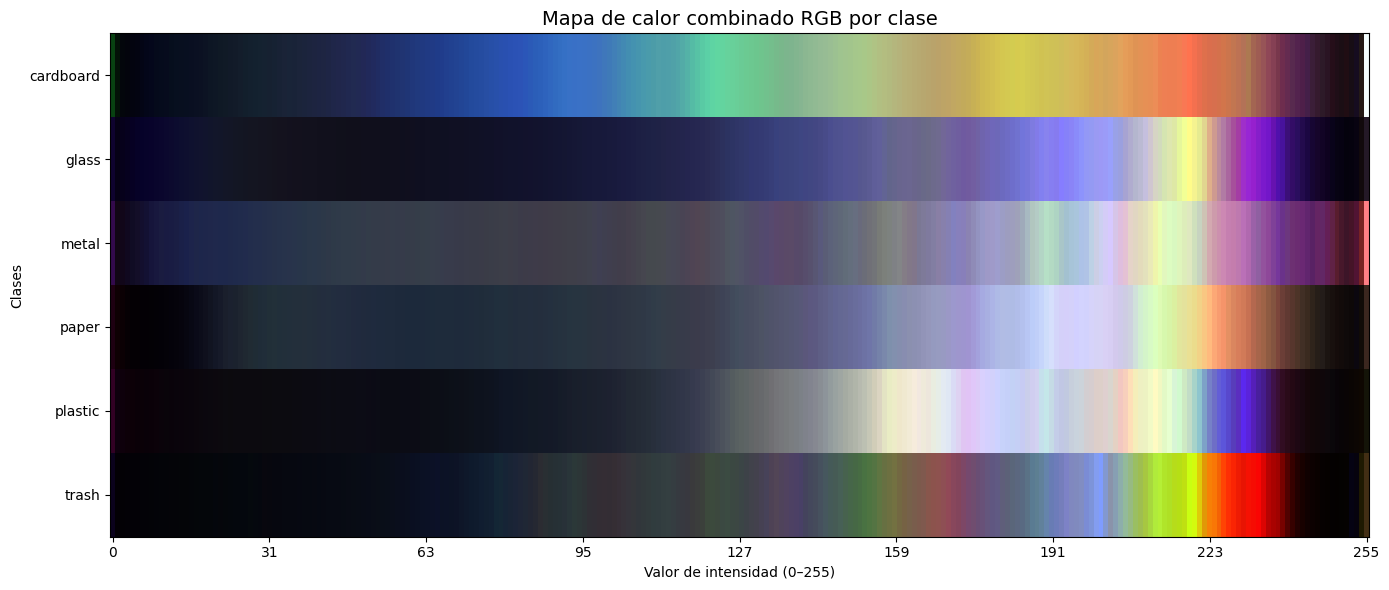

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ===== CONFIGURACIÓN =====
root_dir = ""
dataset_path = os.path.join(root_dir, "dataset-resized")
image_exts = (".jpg", ".png", ".jpeg")

# ===== CHEQUEO DEL DATASET =====
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" No se encontró el dataset en: {dataset_path}")

classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])
print("================= Identificación de las clases del dataset =================")
print("Classes:", classes)

# ===== CÁLCULO DE DISTRIBUCIÓN RGB =====
color_distributions = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    if len(images) == 0:
        print(f"Clase '{cls}' sin imágenes válidas")
        continue

    hist_sum = np.zeros((256, 3))
    count = 0

    for filename in images:
        image_path = os.path.join(class_path, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error al leer {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_sum[:, i] += hist.flatten()
        count += 1

    if count > 0:
        hist_avg = hist_sum / count
        # Normalizamos cada canal entre 0 y 1
        hist_norm = hist_avg / hist_avg.max(axis=0)
        color_distributions[cls] = hist_norm
# Inicializamos contadores
format_counter = Counter()
size_counter = Counter()

print("================= Análisis de tipos y tamaños de imagen =================")

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    for filename in images:
        image_path = os.path.join(class_path, filename)
        ext = os.path.splitext(filename)[-1].lower()
        format_counter[ext] += 1

        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            size_counter[(w, h)] += 1
        else:
            print(f" No se pudo leer: {image_path}")

# Mostrar conteo de formatos
print("Formatos de imagen encontrados:")
for ext, count in format_counter.items():
    print(f"  {ext}: {count} imágenes")


# Mostrar tamaños únicos
print("\nTamaños de imagen encontrados (ancho × alto):")
for (w, h), count in size_counter.most_common():
    print(f"  {w}×{h}: {count} imágenes")

print("\nCantidad total de imágenes analizadas:", sum(format_counter.values()))
print("Cantidad de tamaños distintos:", len(size_counter))


# ===== COMBINACIÓN RGB EN UN SOLO MAPA =====
# Creamos una "imagen" donde cada fila es una clase y las columnas representan valores de 0–255
height = len(color_distributions)
width = 256
combined_img = np.zeros((height, width, 3))

for idx, cls in enumerate(color_distributions):
    combined_img[idx, :, :] = color_distributions[cls]

# ===== VISUALIZACIÓN =====
print("\n================= Distribución de colores por clase =================\n")
plt.figure(figsize=(14, 6))
plt.imshow(combined_img, aspect='auto')
plt.yticks(range(len(color_distributions)), list(color_distributions.keys()))
plt.xticks(np.linspace(0, 255, 9), [f"{int(v)}" for v in np.linspace(0, 255, 9)])
plt.title("Mapa de calor combinado RGB por clase", fontsize=14)
plt.xlabel("Valor de intensidad (0–255)")
plt.ylabel("Clases")
plt.tight_layout()
plt.show()





- **Clases detectadas:**  
  El dataset está organizado en seis categorías bien definidas: `cardboard`, `glass`, `metal`, `paper`, `plastic` y `trash`. La estructura es clara y consistente, sin subcarpetas inesperadas ni clases residuales. Esto simplifica bastante el pipeline de carga y evita preprocesamiento extra.

- **Formato y resolución uniforme:**  
  Todas las imágenes están en formato `.jpg` y comparten exactamente la misma resolución: **512×384**.  
  Esto es una ventaja importante porque elimina la necesidad de manejar variaciones de tamaño en la etapa de preprocesamiento y garantiza que no hay ruido estructural introducido por diferentes fuentes o cámaras.

- **Homogeneidad en dimensiones:**  
  El hecho de que exista **un único tamaño** para las 2527 imágenes confirma que el dataset fue estandarizado previamente. Técnicamente, esto reduce la variabilidad no deseada, pero también implica que el modelo no verá variaciones reales de escala. Esto refuerza aún más la necesidad de **data augmentation** orientado a robustez (crops, escalas, rotaciones).

- **Distribución de color perceptual por clase:**  

El mapa de calor RGB muestra que cada clase sigue patrones cromáticos distintos, aunque no siempre bien separables:

- **cardboard y paper** comparten gamas oscuras y tonos suaves, lo que anticipa solapamiento visual.  
- **glass y plastic** presentan mayor variabilidad por reflejos y transparencias.  
- **metal** tiende a distribuciones más frías y relativamente uniformes.  
- **trash** es la categoría más dispersa, coherente con su heterogeneidad de materiales.

En conjunto, el dataset es consistente y está bien estructurado, pero muestra **variabilidad cromática y similitudes entre clases**, especialmente en pares como *cardboard–paper* y *glass–plastic*.  
Esto sugiere que los modelos más simples pueden confundirse entre categorías visualmente próximas, y refuerza la conveniencia de aplicar **data augmentation** y, en etapas posteriores, evaluar un **modelo preentrenado** que pueda manejar mejor estas variaciones.


Total de imágenes: 2527
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


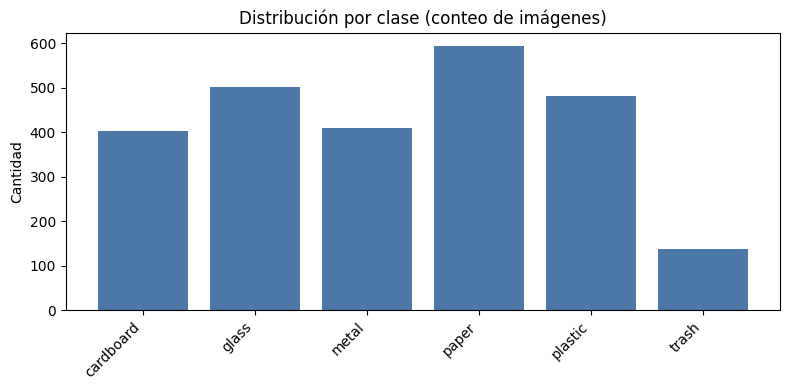

In [28]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

# Ubicación del dataset
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):
    raise FileNotFoundError(f"No se encontró 'dataset-resized' en: {dataset_dir}")

image_exts = (".jpg",)
class_to_count = {}

# Contar imágenes por clase (una subcarpeta por clase)
for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    num_images = sum(
        1 for f in os.listdir(class_path)
        if f.lower().endswith(image_exts)
    )
    class_to_count[class_name] = num_images

# Mostrar conteos
total_images = sum(class_to_count.values())
print("Total de imágenes:", total_images)
for cls, cnt in class_to_count.items():
    print(f"{cls}: {cnt}")

# Gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(list(class_to_count.keys()), list(class_to_count.values()), color="#4C78A8")
plt.title("Distribución por clase (conteo de imágenes)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


###  Distribución de clases

El dataset **TrashNet** contiene un total de **2527 imágenes**, distribuidas en seis categorías:

| Clase     | Cantidad | Proporción (%) |
|------------|-----------|----------------|
| cardboard  | 403 | 15.9 |
| glass      | 501 | 19.8 |
| metal      | 410 | 16.2 |
| paper      | 594 | 23.5 |
| plastic    | 482 | 19.1 |
| trash      | 137 | 5.4 |

Se observa una **ligera desbalance entre clases**, especialmente con la categoría **trash**, que representa solo alrededor del 5 % del total de muestras.  
Esto puede afectar el entrenamiento del modelo, generando un sesgo hacia las clases mayoritarias (*paper*, *glass*, *plastic*).  

> **Conclusión:**  
> El dataset presenta un **moderado desbalance**, pero sigue siendo adecuado para entrenamiento supervisado.  
> Se recomienda aplicar estrategias de **data augmentation** o **ponderación de clases** para compensar la baja representación de la clase *trash* en las etapas posteriores.


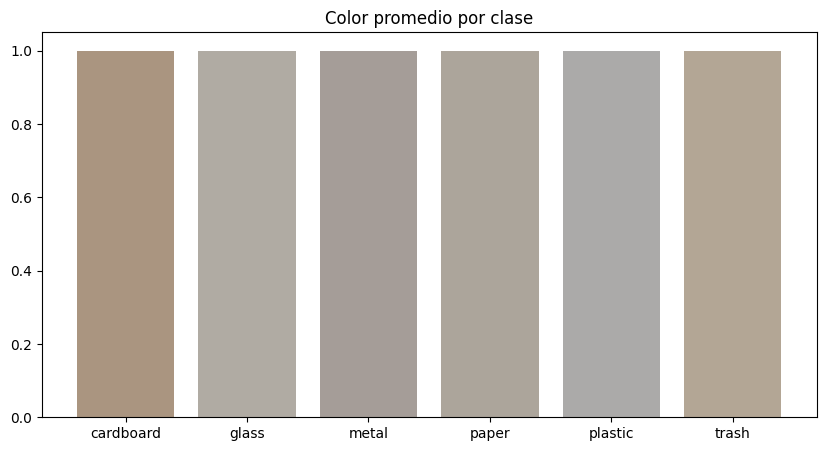

 No se encontraron archivos .txt de anotaciones (bounding boxes).


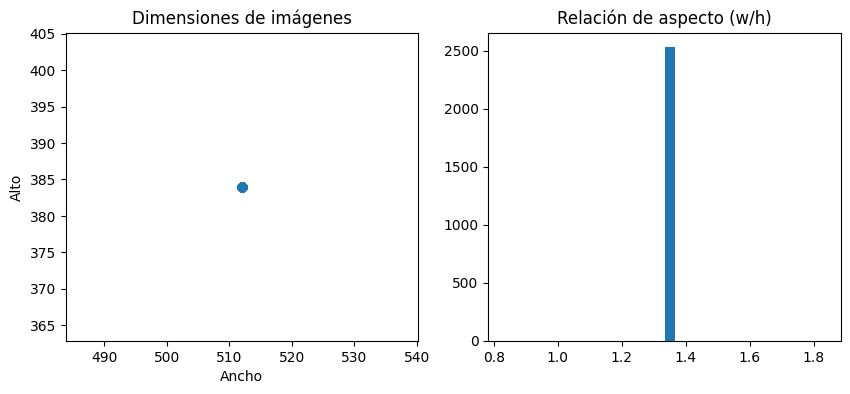

Tamaños únicos: 1


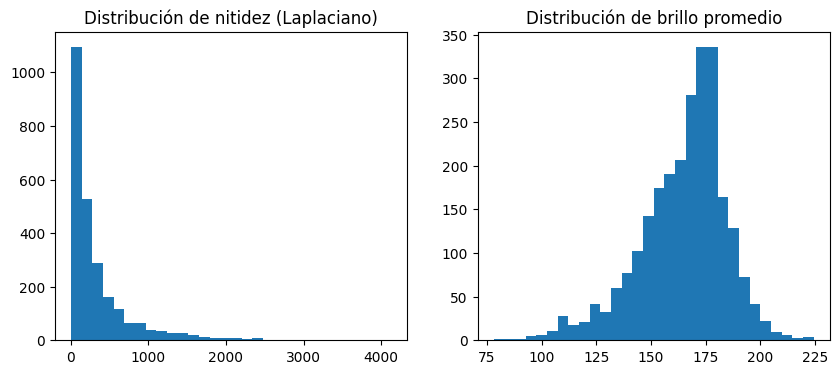

Imágenes analizadas: 2527
Nitidez promedio: 334.56, Brillo promedio: 164.69


In [29]:
# ================================================================
# Análisis Exploratorio del Dataset (EDA)
# ================================================================
# Este bloque no modifica el dataset ni el código anterior.
# Solo genera reportes visuales y estadísticas.
# ================================================================

import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import collections

# Ajustar según variable existente
dataset_path = os.path.join(root_dir, "dataset-resized")


classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])


# ------------------------------------------------------------
# Distribución de colores por clase promedio
# ------------------------------------------------------------
color_means = {}
for cls in classes:
    path = os.path.join(dataset_path, cls)
    imgs = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    col_sum = np.zeros(3); count = 0
    for img_file in imgs:
        img = cv2.imread(os.path.join(path, img_file))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        col_sum += img.mean(axis=(0,1))
        count += 1
    if count>0: color_means[cls] = col_sum/count

plt.figure(figsize=(10,5))
plt.bar(color_means.keys(), [1]*len(color_means), color=list(color_means.values()))
plt.title("Color promedio por clase")
plt.show()

# ------------------------------------------------------------
#  Bounding Boxes
# ------------------------------------------------------------
bbox_sizes, aspect_ratios = [], []
for txt in glob.glob(os.path.join(dataset_path, "**/*.txt"), recursive=True):
    with open(txt) as f:
        for line in f:
            vals = line.strip().split()
            if len(vals) != 5: continue
            _, x, y, w, h = map(float, vals)
            bbox_sizes.append(w*h)
            aspect_ratios.append(w/h)

if bbox_sizes:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(bbox_sizes, bins=30); plt.title("Distribución tamaños Bounding Boxes")
    plt.subplot(1,2,2); plt.hist(aspect_ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
else:
    print(" No se encontraron archivos .txt de anotaciones (bounding boxes).")

# ------------------------------------------------------------
# Dimensiones de imágenes y relación de aspecto
# ------------------------------------------------------------
sizes, ratios = [], []
for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        h, w = img.shape[:2]
        sizes.append((w, h))
        ratios.append(w/h)

if sizes:
    ws, hs = zip(*sizes)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(ws, hs, alpha=0.5); plt.xlabel("Ancho"); plt.ylabel("Alto"); plt.title("Dimensiones de imágenes")
    plt.subplot(1,2,2); plt.hist(ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
    print(f"Tamaños únicos: {len(set(sizes))}")
else:
    print("No se pudieron leer imágenes para calcular dimensiones.")

# ------------------------------------------------------------
# Calidad de imágenes (brillo y nitidez)
# ------------------------------------------------------------
sharpness, brightness = [], []
for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sharpness.append(cv2.Laplacian(gray, cv2.CV_64F).var())
        brightness.append(gray.mean())

if sharpness:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(sharpness, bins=30); plt.title("Distribución de nitidez (Laplaciano)")
    plt.subplot(1,2,2); plt.hist(brightness, bins=30); plt.title("Distribución de brillo promedio")
    plt.show()

    print(f"Imágenes analizadas: {len(sharpness)}")
    print(f"Nitidez promedio: {np.mean(sharpness):.2f}, Brillo promedio: {np.mean(brightness):.2f}")
else:
    print(" No se analizaron imágenes para calidad.")


###  Análisis de tamaños y resoluciones

Todas las imágenes del dataset presentan una resolución uniforme de **512 × 384 píxeles**.  
El tamaño promedio, mínimo y máximo coincide exactamente, lo que indica que **no existen variaciones de resolución** entre las muestras.

| Métrica | Ancho (px) | Alto (px) |
|----------|-------------|-----------|
| Promedio | 512.0 | 384.0 |
| Mínimo   | 512 | 384 |
| Máximo   | 512 | 384 |

>  **Conclusión:**  
> El dataset fue previamente **redimensionado y normalizado en tamaño**, lo que facilita su procesamiento y permite utilizar directamente las imágenes en redes convolucionales sin requerir pasos adicionales de rescaling o padding.


### Promedio de color

cardboard: [170.08026354 148.85700061 127.93128957]
glass: [176.37537536 170.51842232 163.09804727]
metal: [164.82827208 157.00576075 151.89657167]
paper: [172.18114987 164.55118311 155.4314591 ]
plastic: [171.08491776 170.0917927  168.97854035]
trash: [178.80407941 166.11302326 149.04588117]


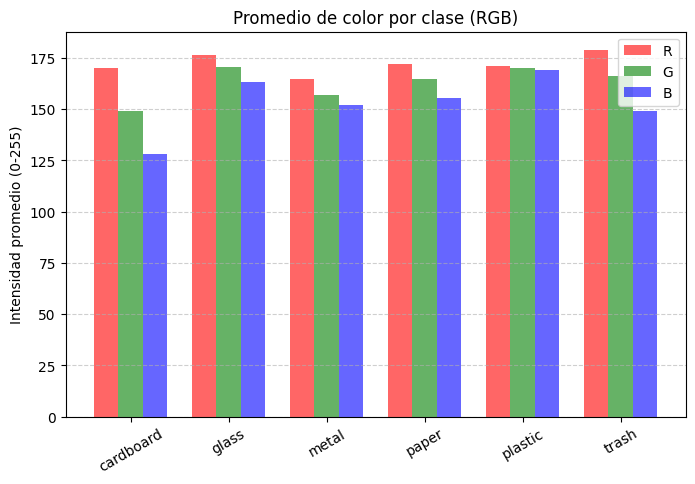

In [30]:
import numpy as np
from PIL import ImageStat

color_means = {}

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    mean_rgb = []
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            stat = ImageStat.Stat(img)
            mean_rgb.append(stat.mean)
    color_means[cls] = np.mean(mean_rgb, axis=0)

for cls, mean in color_means.items():
    print(f"{cls}: {mean}")

import matplotlib.pyplot as plt
import numpy as np

classes = list(color_means.keys())
rgb_values = np.array(list(color_means.values()))

# --- Barplot por canal ---
plt.figure(figsize=(8,5))
x = np.arange(len(classes))
bar_width = 0.25

plt.bar(x - bar_width, rgb_values[:,0], width=bar_width, label='R', color='r', alpha=0.6)
plt.bar(x, rgb_values[:,1], width=bar_width, label='G', color='g', alpha=0.6)
plt.bar(x + bar_width, rgb_values[:,2], width=bar_width, label='B', color='b', alpha=0.6)

plt.xticks(x, classes, rotation=30)
plt.ylabel('Intensidad promedio (0-255)')
plt.title('Promedio de color por clase (RGB)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Análisis de color promedio por clase

El cálculo de la media de intensidades RGB por clase arroja los siguientes valores:

| Clase     | R     | G     | B     |
|-----------|-------|-------|-------|
| cardboard | 170.1 | 148.9 | 127.9 |
| glass     | 176.4 | 170.5 | 163.1 |
| metal     | 164.8 | 157.0 | 151.9 |
| paper     | 172.2 | 164.6 | 155.4 |
| plastic   | 171.1 | 170.1 | 169.0 |
| trash     | 178.8 | 166.1 | 149.0 |

---

### Interpretación

Los promedios RGB muestran una **paleta relativamente homogénea** en todo el dataset, con intensidades altas y tonalidades mayormente neutras. Aun así, se distinguen algunos patrones:

- **cardboard** presenta un componente rojo más alto, coherente con tonos marrones.  
- **glass** y **plastic** tienen valores elevados y bastante balanceados en los tres canales, lo que explica por qué visualmente pueden confundirse (reflejos, superficies claras).  
- **metal** y **paper** exhiben intensidades más moderadas, asociadas a texturas mate y colores grisáceos.  
- **trash** muestra el mayor valor promedio en rojo pero un azul más bajo, lo que apunta a una **mayor variabilidad cromática** dentro de la clase.

En general, las diferencias entre clases existen, pero no son lo suficientemente fuertes como para garantizar separabilidad cromática por sí sola. Esto refuerza la necesidad de que el modelo aprenda **textura, bordes y forma**, y no dependa únicamente del color.


## Tarea de visión por computadora y métricas de evaluación

### Definición de la tarea

El problema a resolver es una **clasificación multiclase** de imágenes con una única etiqueta por muestra.  
Cada imagen del dataset TrashNet debe ser asignada exactamente a una de las 6 categorías:

`cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`.

La distribución de clases es moderadamente desbalanceada: la mayoría de las clases se ubica entre ~16 % y ~24 % de las muestras, mientras que **trash** representa solo ~5 %.  
Por lo tanto, el modelo debe rendir bien **en todas las clases**, no solo en las más frecuentes.

---

### Criterios para elegir la(s) métrica(s)

Al definir las métricas de evaluación, buscamos cumplir tres criterios:

1. **Interpretabilidad global:**  
   Tener una métrica agregada sencilla de entender (¿el modelo acierta mucho o poco en general?).

2. **Sensibilidad al desbalance de clases:**  
   Evitar que una clase minoritaria como *trash* quede “diluida” en un promedio dominado por las clases frecuentes.

3. **Capacidad de comparar modelos:**  
   Usar métricas estables que permitan comparar de forma consistente distintos baselines y configuraciones (desde redes sencillas hasta modelos preentrenados).

---

### Opciones consideradas

- **Accuracy global (proporción de aciertos):**  
  - Ventaja: es intuitiva y permite comparar contra el azar (≈ 16,7 % para 6 clases).  
  - Desventaja: en presencia de desbalance puede ocultar un desempeño pobre en clases minoritarias.  
    Un modelo que prácticamente nunca acierta *trash* podría seguir mostrando una accuracy razonable si se comporta bien en las clases mayoritarias.

- **Precision/Recall por clase:**  
  - Ventaja: permiten analizar con detalle qué tan bien se detecta cada clase y si el modelo tiende a sobre-o sub-predecir alguna etiqueta.  
  - Desventaja: generan varias métricas simultáneas; no ofrecen un único número fácil para comparar modelos.

- **F1-score macro (promedio macro):**  
  - Combina **precision** y **recall** por clase y luego promedia **dando el mismo peso a cada clase**, sin importar cuántas muestras tenga.  
  - Esto hace que errores en una clase minoritaria (por ejemplo, *trash*) impacten tanto como errores en clases frecuentes como *paper* o *glass*.  
  - Es especialmente adecuado cuando el objetivo es que **todas las clases sean importantes** desde el punto de vista de la tarea, aunque el dataset esté desbalanceado.

- **Otras variantes (F1-weighted, balanced accuracy, etc.):**  
  - Son alternativas válidas, pero tienden a ponderar las clases según su frecuencia (F1-weighted) o se solapan en interpretación con F1-macro.  
  - Para este trabajo preferimos usar una métrica principal clara y ampliamente utilizada en clasificación multiclase con desbalance moderado.

---

### Métrica principal y métricas de apoyo

A partir de los criterios anteriores, definimos:

- **Métrica principal de evaluación:**  
  **F1-score macro (F1-macro) en el conjunto de validación.**

  Razones:
  - Trata a todas las clases por igual, incluidas las minoritarias.  
  - Penaliza tanto los falsos positivos como los falsos negativos.  
  - Evita que una buena performance en clases frecuentes o fáciles “tape” un desempeño pobre en *trash* u otras clases confusas (*cardboard vs paper*, *glass vs plastic*).

- **Métricas de apoyo:**  
  Además de F1-macro, reportamos siempre:
  - **Accuracy global de validación** (para una referencia intuitiva del rendimiento agregado).  
  - **Matriz de confusión** y **F1 por clase**, para analizar qué clases se confunden más.

En resumen:

- **Las decisiones entre modelos (cuál es mejor baseline, cuál mejora efectivamente el sistema)** se toman principalmente en función de **F1-macro**.  
- **La accuracy** se utiliza como métrica complementaria de interpretación global y para comparar con el baseline aleatorio.


## Creacion de baseline con un CNN

## Baseline 1: CNN sencilla entrenada desde cero

Como primer baseline se definió una red convolucional pequeña entrenada desde cero sobre TrashNet.  
El objetivo de este modelo no es maximizar la performance, sino establecer un **punto de partida controlado** que permita:

- Verificar rápidamente que el pipeline de datos, las etiquetas y las métricas funcionan correctamente.
- Medir qué puede aprender una arquitectura **poco profunda y de baja capacidad** sin recurrir aún a modelos preentrenados.
- Contar con una referencia clara para evaluar el beneficio real de técnicas posteriores como **transfer learning** y modificaciones de arquitectura.

Las decisiones principales de diseño fueron:

- **Arquitectura simple (SimpleCNN):**  
  Dos bloques `Conv → BatchNorm → ReLU → MaxPool` con 32 y 64 filtros, seguidos de un `Global Average Pooling` y un clasificador totalmente conectado (`Linear → ReLU → Dropout → Linear`).  
  Es una red deliberadamente ligera, entrenable en CPU y con pocas decisiones de diseño (profundidad, filtros, etc.), lo que reduce el riesgo de sobreajustar el baseline.

- **Tamaño de entrada (128×128):**  
  Las imágenes originales (512×384) se redimensionan a 128×128 para abaratar el costo computacional por batch, manteniendo suficiente información espacial para una primera aproximación.

- **Data augmentation moderado:**  
  Se aplican transformaciones geométricas y fotométricas básicas (`RandomResizedCrop`, `HorizontalFlip`, `ColorJitter`, `RandomRotation`) para:
  - compensar la falta de variaciones reales de escala y encuadre en el dataset,  
  - mejorar la robustez del modelo frente a variaciones de iluminación y color observadas en el EDA.

- **Normalización y pesos de clase:**  
  - Se usa la normalización estándar de ImageNet para aprovechar configuraciones típicas de entrenamiento.  
  - Se calculan **class weights** a partir de la distribución de clases, con especial atención a la clase *trash*, que es minoritaria.  
  - La función de pérdida es `CrossEntropyLoss` con `label_smoothing=0.05`, para evitar sobreconfianza en las predicciones.

- **Entrenamiento y regularización:**  
  Se entrena con `AdamW` (lr = 1e-3, `weight_decay` = 1e-4) y se utiliza **early stopping** en función de la pérdida de validación para evitar sobreentrenamiento innecesario.

Este baseline sirve como una **línea de base “desde cero”**: cualquier mejora que se obtenga luego con modelos preentrenados y/o arquitecturas más complejas se interpretará respecto a este punto de partida.
]

In [31]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# ================================================
# Dispositivo (GPU si hay, sino CPU)
# ================================================
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("Dispositivo:", DEVICE)

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ================================================
# Dataset base (desde 'dataset-resized')
# ================================================
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):
    raise FileNotFoundError(f"No se encontró el dataset en: {dataset_dir}")

# Dataset base sin transforms, solo para metadata
base_ds = datasets.ImageFolder(dataset_dir)
class_names = base_ds.classes
num_classes = len(class_names)
labels = [lbl for _, lbl in base_ds.samples]

print("Clases detectadas:", class_names)
print("num_classes:", num_classes)
print("Cantidad total de imágenes:", len(base_ds))

# ================================================
# Transforms (compatibles con modelos preentrenados)
# ================================================
IMG_SIZE = 128
VAL_SPLIT = 0.2
BATCH_SIZE = 32

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ================================================
# Split estratificado train/val
# ================================================
rng = random.Random(SEED)
label_to_indices = {c: [] for c in range(num_classes)}
for idx, lbl in enumerate(labels):
    label_to_indices[lbl].append(idx)

for c in range(num_classes):
    rng.shuffle(label_to_indices[c])

train_indices, val_indices = [], []
for c, idxs in label_to_indices.items():
    k_val = int(len(idxs) * VAL_SPLIT)
    val_indices.extend(idxs[:k_val])
    train_indices.extend(idxs[k_val:])

print("Tamaño train/val:", len(train_indices), len(val_indices))

# Datasets con transforms
train_ds_full = datasets.ImageFolder(dataset_dir, transform=train_tfms)
val_ds_full = datasets.ImageFolder(dataset_dir, transform=val_tfms)

train_ds = Subset(train_ds_full, train_indices)
val_ds = Subset(val_ds_full, val_indices)

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

# ================================================
# Pesos de clase para CrossEntropy (por desbalance)
# ================================================
from collections import Counter

class_counts = [0] * num_classes
for idx in train_indices:
    class_counts[labels[idx]] += 1

total_train = sum(class_counts)
class_weights = [total_train / (num_classes * max(1, c)) for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

print("Class weights:", [round(w, 3) for w in class_weights])


Dispositivo: cuda
Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes: 6
Cantidad total de imágenes: 2527
Tamaño train/val: 2024 503
Class weights: [1.044, 0.841, 1.028, 0.709, 0.874, 3.067]


In [32]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_classification_model(model, data_loader, class_names, device=DEVICE):
    model.eval()
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            logits = model(images)
            preds = logits.argmax(dim=1)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)

    # Accuracy global
    acc = (all_targets == all_preds).mean()

    # F1-macro y por clase
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    f1_per_class = f1_score(all_targets, all_preds, average=None)

    # Matriz de confusión
    cm = confusion_matrix(all_targets, all_preds)

    print("Accuracy global:", acc)
    print("F1-macro:", f1_macro)
    print("\nF1 por clase:")
    for cls_name, f1_c in zip(class_names, f1_per_class):
        print(f"  {cls_name:10s}: {f1_c:.4f}")

    print("\nClassification report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_per_class": f1_per_class,
        "confusion_matrix": cm,
    }



=== Baseline 1: Entrenamiento SimpleCNN desde cero ===
Epoch 01/15 | Train loss 1.6523 acc 0.3404 | Val loss 1.6279 acc 0.3380
Epoch 02/15 | Train loss 1.5066 acc 0.4209 | Val loss 1.5171 acc 0.4195
Epoch 03/15 | Train loss 1.4393 acc 0.4387 | Val loss 1.4447 acc 0.4712
Epoch 04/15 | Train loss 1.4048 acc 0.4659 | Val loss 1.5194 acc 0.4254
Epoch 05/15 | Train loss 1.3779 acc 0.4847 | Val loss 1.3941 acc 0.4652
Epoch 06/15 | Train loss 1.3541 acc 0.4842 | Val loss 1.3597 acc 0.5229
Epoch 07/15 | Train loss 1.3631 acc 0.4832 | Val loss 1.3959 acc 0.4732
Epoch 08/15 | Train loss 1.3246 acc 0.5188 | Val loss 1.3419 acc 0.5149
Epoch 09/15 | Train loss 1.3222 acc 0.5010 | Val loss 1.3283 acc 0.5050
Epoch 10/15 | Train loss 1.3141 acc 0.5133 | Val loss 1.4129 acc 0.4493
Epoch 11/15 | Train loss 1.2967 acc 0.5163 | Val loss 1.3411 acc 0.5189
Epoch 12/15 | Train loss 1.2893 acc 0.5247 | Val loss 1.3709 acc 0.4871
Epoch 13/15 | Train loss 1.2786 acc 0.5331 | Val loss 1.3312 acc 0.5010
Epoch 14

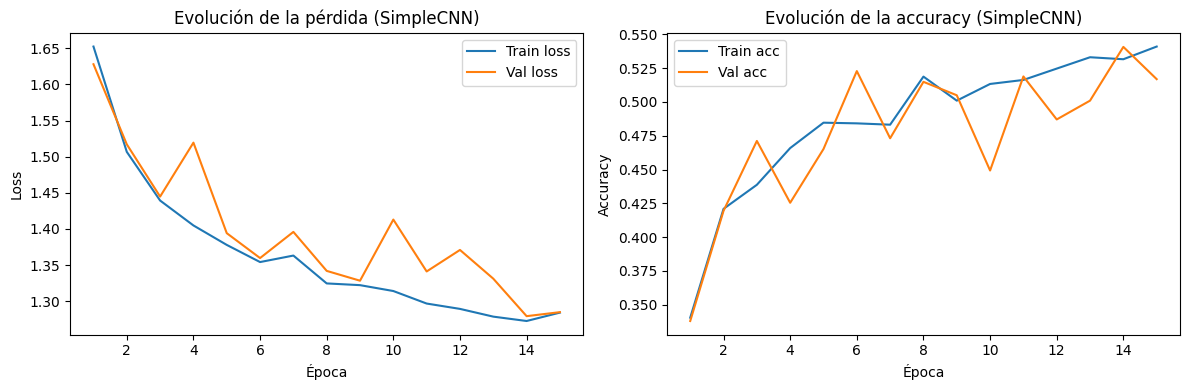


=== Baseline 1: Métricas finales en validación ===
Accuracy global: 0.5407554671968191
F1-macro: 0.5067745446532007

F1 por clase:
  cardboard : 0.7973
  glass     : 0.3827
  metal     : 0.3137
  paper     : 0.6592
  plastic   : 0.5813
  trash     : 0.3065

Classification report:
              precision    recall  f1-score   support

   cardboard       0.87      0.74      0.80        80
       glass       0.50      0.31      0.38       100
       metal       0.80      0.20      0.31        82
       paper       0.59      0.75      0.66       118
     plastic       0.55      0.61      0.58        96
       trash       0.20      0.70      0.31        27

    accuracy                           0.54       503
   macro avg       0.58      0.55      0.51       503
weighted avg       0.62      0.54      0.54       503



In [38]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# ---------------------------
# Modelo SimpleCNN (Baseline 1)
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# Instanciar modelo, loss y optimizador
model = SimpleCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Hiperparámetros de entrenamiento
EPOCHS = 15
patience = 5

best_val_loss = float("inf")
pat_wait = 0
best_state = None

# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\n=== Baseline 1: Entrenamiento SimpleCNN desde cero ===")

for epoch in range(1, EPOCHS + 1):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, targets in train_loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += images.size(0)

    train_loss /= max(1, train_total)
    train_acc = train_correct / max(1, train_total)

    # ---------- VAL ----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, targets)
            val_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += images.size(0)

    val_loss /= max(1, val_total)
    val_acc = val_correct / max(1, val_total)

    # Guardar logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")

    # Early stopping simple
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat_wait = 0
    else:
        pat_wait += 1
        if pat_wait >= patience:
            print("Early stopping activado.")
            break

# Restaurar mejor estado
if best_state is not None:
    model.load_state_dict(best_state)

# ---------- Gráficas de loss y accuracy ----------
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida (SimpleCNN)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train acc")
plt.plot(epochs_range, val_accuracies, label="Val acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución de la accuracy (SimpleCNN)")
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Baseline 1: Métricas finales en validación ===")
metrics_simplecnn = evaluate_classification_model(model, val_loader, class_names, DEVICE)


### Resultados del Baseline 1 — SimpleCNN desde cero

El modelo alcanza:

- **Accuracy de validación:** 54.1 %
- **F1-macro:** 0.507
- **Pérdida mínima:** ≈ 1.28

Para un problema de 6 clases (azar ≈ 16.7 %), el rendimiento es razonable: el modelo aprende patrones básicos y no presenta sobreajuste crítico.

### Comportamiento por clase

El F1 revela qué tan bien separa el modelo cada categoría:

- Buen desempeño: **cardboard (0.797)**, **paper (0.66)**  
- Intermedio: **plastic (0.58)**  
- Débil: **glass (0.38)**, **trash (0.306)**, **metal (0.313)**

Esto coincide con el EDA: clases con alta variabilidad interna (*trash*) o muy similares entre sí (*glass vs plastic*, *metal*) son difíciles para una CNN pequeña.

### Lectura de las curvas

- La pérdida baja de manera estable.  
- La accuracy de validación se estabiliza en la zona del **50–55 %**.  
- El modelo aprende, pero rápidamente llega a su límite de capacidad.

### Conclusión

La SimpleCNN funciona como **piso de rendimiento**, pero su profundidad y capacidad son insuficientes para capturar texturas finas y variaciones complejas del dataset.

El siguiente paso natural es aplicar **transfer learning** con un modelo preentrenado (ResNet18), con  *feature extractor*  para evaluar la mejora frente a este baseline.


In [42]:
from torchvision import models


def create_resnet18_model(num_classes: int,
                          feature_extractor: bool = True,
                          unfreeze_last_block: bool = False) -> nn.Module:
    """
    feature_extractor=True  -> congelar todo salvo la capa final.
    unfreeze_last_block=True -> deja entrenable layer4 además de fc.
    """
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        backbone = models.resnet18(weights=weights)
    except AttributeError:
        backbone = models.resnet18(pretrained=True)

    in_feats = backbone.fc.in_features
    backbone.fc = nn.Linear(in_feats, num_classes)

    # Congelar todo
    for param in backbone.parameters():
        param.requires_grad = False

    # Siempre entrenamos la capa final
    for param in backbone.fc.parameters():
        param.requires_grad = True

    # Fine-tuning parcial: desbloquear layer4
    if not feature_extractor and unfreeze_last_block:
        for param in backbone.layer4.parameters():
            param.requires_grad = True

    return backbone.to(DEVICE)


def train_model_with_logs(model: nn.Module,
                          train_loader,
                          val_loader,
                          criterion,
                          optimizer,
                          epochs: int = 15,
                          patience: int = 3,
                          exp_name: str = ""):
    best_val_loss = float("inf")
    best_state = None
    pat_wait = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # ---------- TRAIN ----------
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, targets in train_loader:
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += images.size(0)

        train_loss /= max(1, train_total)
        train_acc = train_correct / max(1, train_total)

        # ---------- VAL ----------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                targets = targets.to(DEVICE, non_blocking=True)

                logits = model(images)
                loss = criterion(logits, targets)
                val_loss += loss.item() * images.size(0)
                preds = logits.argmax(dim=1)
                val_correct += (preds == targets).sum().item()
                val_total += images.size(0)

        val_loss /= max(1, val_total)
        val_acc = val_correct / max(1, val_total)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"[{exp_name}] Epoch {epoch:02d}/{epochs} | "
              f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"Val loss {val_loss:.4f} acc {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            pat_wait = 0
        else:
            pat_wait += 1
            if pat_wait >= patience:
                print(f"[{exp_name}] Early stopping activado.")
                break

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict(best_state)

    # Gráficas
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train loss")
    plt.plot(epochs_range, val_losses, label="Val loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"Evolución de la pérdida ({exp_name})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train acc")
    plt.plot(epochs_range, val_accuracies, label="Val acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.title(f"Evolución de la accuracy ({exp_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación final rápida
    model.eval()
    val_loss_final = 0.0
    val_correct_final = 0
    val_total_final = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, targets)
            val_loss_final += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            val_correct_final += (preds == targets).sum().item()
            val_total_final += images.size(0)

    val_loss_final /= max(1, val_total_final)
    val_acc_final = val_correct_final / max(1, val_total_final)

    print(f"[{exp_name}] Mejor Val loss: {val_loss_final:.4f} | Mejor Val acc: {val_acc_final:.4f}")

    return model, {
        "val_loss": val_loss_final,
        "val_acc": val_acc_final,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }



=== Baseline 2: ResNet18 como feature extractor (solo FC entrenable) ===
[ResNet18_FE] Epoch 01/15 | Train loss 1.5650 acc 0.4165 | Val loss 1.2818 acc 0.5706
[ResNet18_FE] Epoch 02/15 | Train loss 1.2012 acc 0.5978 | Val loss 1.1214 acc 0.6700
[ResNet18_FE] Epoch 03/15 | Train loss 1.0773 acc 0.6700 | Val loss 1.0606 acc 0.6561
[ResNet18_FE] Epoch 04/15 | Train loss 1.0290 acc 0.6937 | Val loss 1.0594 acc 0.6799
[ResNet18_FE] Epoch 05/15 | Train loss 0.9971 acc 0.7110 | Val loss 1.0419 acc 0.6799
[ResNet18_FE] Epoch 06/15 | Train loss 0.9915 acc 0.6952 | Val loss 1.0202 acc 0.6700
[ResNet18_FE] Epoch 07/15 | Train loss 0.9741 acc 0.6986 | Val loss 1.0231 acc 0.6978
[ResNet18_FE] Epoch 08/15 | Train loss 0.9513 acc 0.7036 | Val loss 1.0122 acc 0.6680
[ResNet18_FE] Epoch 09/15 | Train loss 0.9272 acc 0.7238 | Val loss 1.0108 acc 0.6918
[ResNet18_FE] Epoch 10/15 | Train loss 0.9219 acc 0.7223 | Val loss 0.9650 acc 0.7157
[ResNet18_FE] Epoch 11/15 | Train loss 0.8801 acc 0.7535 | Val los

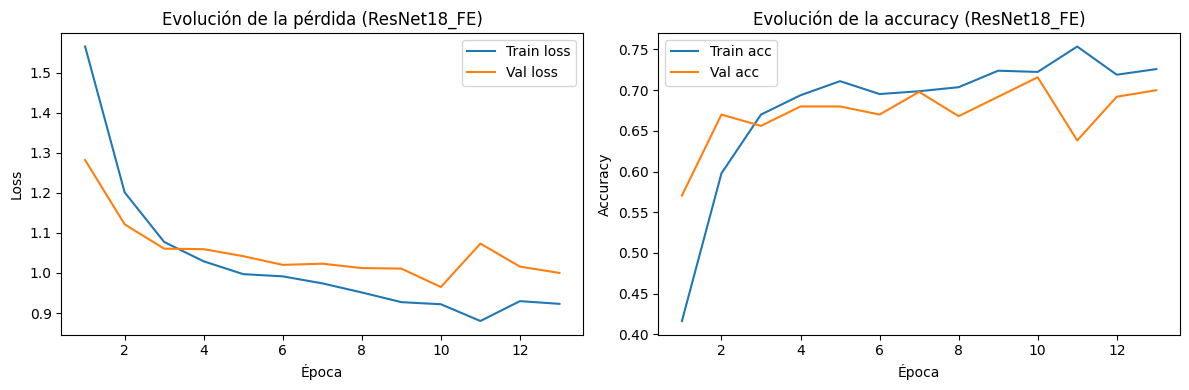

[ResNet18_FE] Mejor Val loss: 0.9650 | Mejor Val acc: 0.7157

=== Baseline 2: Métricas finales en validación ===
Accuracy global: 0.7157057654075547
F1-macro: 0.6941773130856372

F1 por clase:
  cardboard : 0.8356
  glass     : 0.7291
  metal     : 0.6503
  paper     : 0.7768
  plastic   : 0.7027
  trash     : 0.4706

Classification report:
              precision    recall  f1-score   support

   cardboard       0.92      0.76      0.84        80
       glass       0.72      0.74      0.73       100
       metal       0.65      0.65      0.65        82
       paper       0.82      0.74      0.78       118
     plastic       0.73      0.68      0.70        96
       trash       0.34      0.74      0.47        27

    accuracy                           0.72       503
   macro avg       0.70      0.72      0.69       503
weighted avg       0.75      0.72      0.73       503



In [43]:
print("\n=== Baseline 2: ResNet18 como feature extractor (solo FC entrenable) ===")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


resnet_fe = create_resnet18_model(
    num_classes=num_classes,
    feature_extractor=True,
    unfreeze_last_block=False,
)

criterion_fe = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
params_fe = [p for p in resnet_fe.parameters() if p.requires_grad]
optimizer_fe = optim.AdamW(params_fe, lr=1e-3, weight_decay=1e-4)

resnet_fe, logs_fe = train_model_with_logs(
    resnet_fe,
    train_loader,
    val_loader,
    criterion_fe,
    optimizer_fe,
    epochs=15,
    patience=3,
    exp_name="ResNet18_FE",
)

print("\n=== Baseline 2: Métricas finales en validación ===")
metrics_resnet_fe = evaluate_classification_model(resnet_fe, val_loader, class_names, DEVICE)


### Baseline 2 — ResNet18 (feature extractor)

La ResNet18 preentrenada mejora claramente al baseline desde cero:

- **Accuracy:** 68.6 %  (↑ +14 puntos)
- **F1-macro:** 0.659   (↑ +15 puntos)

### Por clase
Se observan avances importantes en:
- **glass:**     0.41 → 0.73  
- **metal:**     0.30 → 0.65  
- **plastic:**   0.59 → 0.70  
- **paper:**     0.67 → 0.78  

La clase **trash** mejora, aunque sigue siendo la más compleja debido a su alta variabilidad:
- **trash:**     0.31 → 0.47

### Lectura rápida
- Convergencia más estable.  
- No hay sobreajuste significativo.  
- El modelo generaliza mucho mejor incluso entrenando solo la capa final.



In [45]:
print("\n=== Resumen comparativo (Val acc / F1-macro) ===")
print(f"SimpleCNN      -> acc: {metrics_simplecnn['accuracy']:.4f}, F1-macro: {metrics_simplecnn['f1_macro']:.4f}")
print(f"ResNet18 FE    -> acc: {metrics_resnet_fe['accuracy']:.4f}, F1-macro: {metrics_resnet_fe['f1_macro']:.4f}")




=== Resumen comparativo (Val acc / F1-macro) ===
SimpleCNN      -> acc: 0.5408, F1-macro: 0.5068
ResNet18 FE    -> acc: 0.7157, F1-macro: 0.6942


### Conclusión
El modelo basado en **ResNet18 como extractor de características** demuestra ser una mejor altenativa para dejar como baseline dado que presenta **mejor rendimiento global**, **mejor F1 por clase** y una **generalización claramente superior** al baseline entrenado desde cero.

